In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from pa_lib.file import store_bin, project_dir, data_files, load_csv, load_bin, write_xlsx
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.util import collect, value
from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data

In [2]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_labels = load_bin("ax_var_labels.feather")

var = Record(**{v: v for v in ax_data['Variable'].unique()})
stat = Record(**{s: s for s in ax_data['Station'].unique()})

2019-09-30 16:58:34 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
2019-09-30 16:58:34 [INFO] Finished loading binary file in 0.12s (0.47s CPU)
2019-09-30 16:58:34 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_labels.feather
2019-09-30 16:58:34 [INFO] Finished loading binary file in 0.0s (0.0s CPU)


In [3]:
def var_label(variable):
    return ax_var_labels.set_index("Variable").at[variable, "Label"]

In [4]:
weekday_order = ax_data.DayOfWeek.cat.categories.to_list()
timeSlot_order = ax_data.TimeSlot.cat.categories.to_list()

with value(ax_data.DayOfWeek.isin(["Saturday", "Sunday"])) as weekend_rows:
    ax_data_weekends = ax_data.loc[weekend_rows].pipe(clean_up_categoricals)
    ax_data_workdays = ax_data.loc[~weekend_rows].pipe(clean_up_categoricals)

In [5]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/6172735,27,5.9 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/6172735,7,5.9 MB,"[Monday,Sunday]"
Time,category,0/6172735,96,5.9 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/6172735,117,5.9 MB,"[g_220,nat_ausland]"
Code,category,0/6172735,155,11.8 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/6172735,343130,47.1 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/6172735,1,5.9 MB,"[2019,2019]"
Month,category,0/6172735,4,5.9 MB,"[05,08]"
logValue,float64,0/6172735,343130,47.1 MB,"[-0.7359711777508736,4.0614768513453585]"
VarDesc,category,0/6172735,117,5.9 MB,"[Abteilungs-/Teamleitung,kein Mobiltelefon]"


## Define code order, where necessary

In [6]:
var_code_order = {
    "md_agenatrep": {
        "14-29 Jahre": 1,
        "30-45 Jahre": 2,
        "46-60 Jahre": 3,
        "61+ Jahre": 4,
    },
    "md_bildung3": {
        "niedrig (kein Abschluss, obligat. Schule, HH-Lehrjahr, Handelsschule, Anlehre)": 1,
        "mittel (Diplommittelschule, allg. Schule, Berufslehre, Vollzeitberufsschule, Maturität, Lehrerseminar)": 2,
        "hoch (Universität, ETH, FH, PH, höhere Berufsausbildung)": 3,
    },
    "md_hhgr3": {"1 Person": 1, "2 Personen": 2, "3+ Personen": 3},
    "g_privatetrainuse": {
        "Nie": 1,
        "1-2 Mal jährlich": 2,
        "3-12 Mal jährlich": 3,
        "2-5 Mal pro Monat": 4,
        "6 Mal pro Monat oder häufiger": 5,
    },
    "md_203": {  # Bahnnutzung beruflich
        "Nie": 1,
        "Seltener": 2,
        "Etwa zu einem Viertel": 3,
        "Etwa zur Hälfte": 4,
        "Meistens": 5,
        "Immer": 6,
    },
    "g_220": {  # Autos im Haushalt
        "Keines": 1,
        "1 Auto": 2,
        "2 Autos": 3,
        "3 Autos": 4,
        "Mehr als 3 Autos": 5,
    },
    "md_410": {  # Internetnutzung
        "seltener": 1,
        "mehrmals pro Monat": 2,
        "einmal pro Woche": 3,
        "mehrmals pro Woche": 4,
        "täglich/fast täglich": 5,
    },
    # Div.Internet-Nutzungsarten (md_421 bis md_411)
    "md_421": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_419": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_417": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_416": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_415": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_414": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_413": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_412": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_411": {"nie": 1, "gelegentlich": 2, "regelmässig": 3},
    "md_early": {
        "Ich bin immer einer/eine der ersten, der/die neue Technologien und Geräte kauft resp. einsetzt.": 1,
        "Ich fange erst dann an, neue Technologien und Geräte zu verwenden, wenn ich weiss, welche Erfahrungen andere mit ihnen gemacht haben.": 2,
        "Ich übernehme neue Technologien und Geräte erst dann, wenn es für mich persönlich oder beruflich unerlässlich ist.": 3,
    },
    "md_tv": {"kein TV-Gerät": 1, "1 oder mehrere TV-Geräte": 2},
    "g_TvChannelsgroup": {
        "keine Sender": 1,
        "1-4 Sender": 2,
        "5-9 Sender": 3,
        "10++ Sender": 4,
    },
    "g_flug": {"keine Flüge": 1, "1 - 4 Flüge": 2, "5 - 9 Flüge": 3, "10++ Flüge": 4},
    "g_flugBusiness": {
        "keine Flüge": 1,
        "1 - 4 Flüge": 2,
        "5 - 9 Flüge": 3,
        "10++ Flüge": 4,
    },
    "md_ek": {
        "Keine Angabe": 0,
        "Weniger als 3'000 CHF": 1,
        "Zwischen 3'000 und 4'500 CHF": 2,
        "Zwischen 4'501 und 6'000 CHF": 3,
        "Zwischen 6'001 und 9'000 CHF": 4,
        "Zwischen 9'001 und 12'000 CHF": 5,
        "Mehr als 12'000 CHF": 6,
    },
    "md_hhverm": {
        "Keine Angabe": 0,
        "Weniger als CHF 50 000": 1,
        "Zwischen CHF 50 000 und CHF 100 000": 2,
        "Zwischen CHF 100 000 und CHF 250 000": 3,
        "Zwischen CHF 250 000 und CHF 500 000": 4,
        "Zwischen CHF 500 000 und CHF 1 Mio.": 5,
        "Zwischen CHF 1 Mio. und CHF 5 Mio.": 6,
        "Mehr als CHF 5 Mio.": 7,
    },
}

# Check distributions

## Time

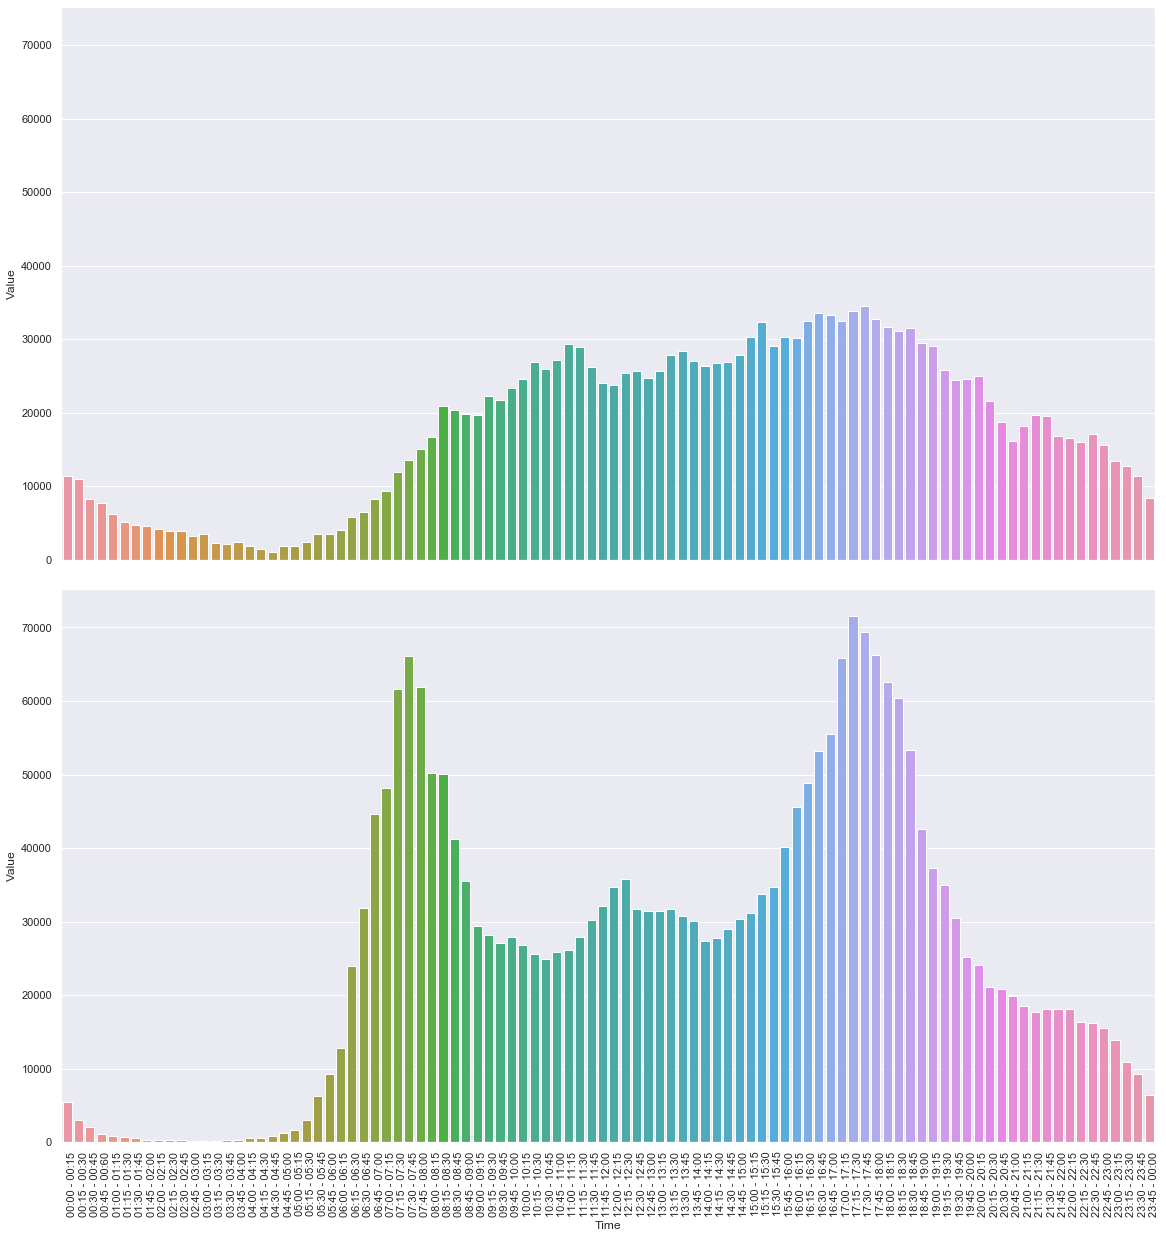

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"), # average workday
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"), # average weekend day
    x="Time",
    y="Value",
    ci=None,
    estimator=np.sum,
    ax=ax_weekend,
)
fig.autofmt_xdate(rotation=90, ha="left")

### Time by Weekday

In [ ]:
sns.catplot(
    data=ax_data,
    kind="bar",
    x="Time",
    y="Value",
    row="DayOfWeek",
    row_order=weekday_order,
    ci=None,
    estimator=np.sum,
    height=6,
    aspect=2,
)

## Hours

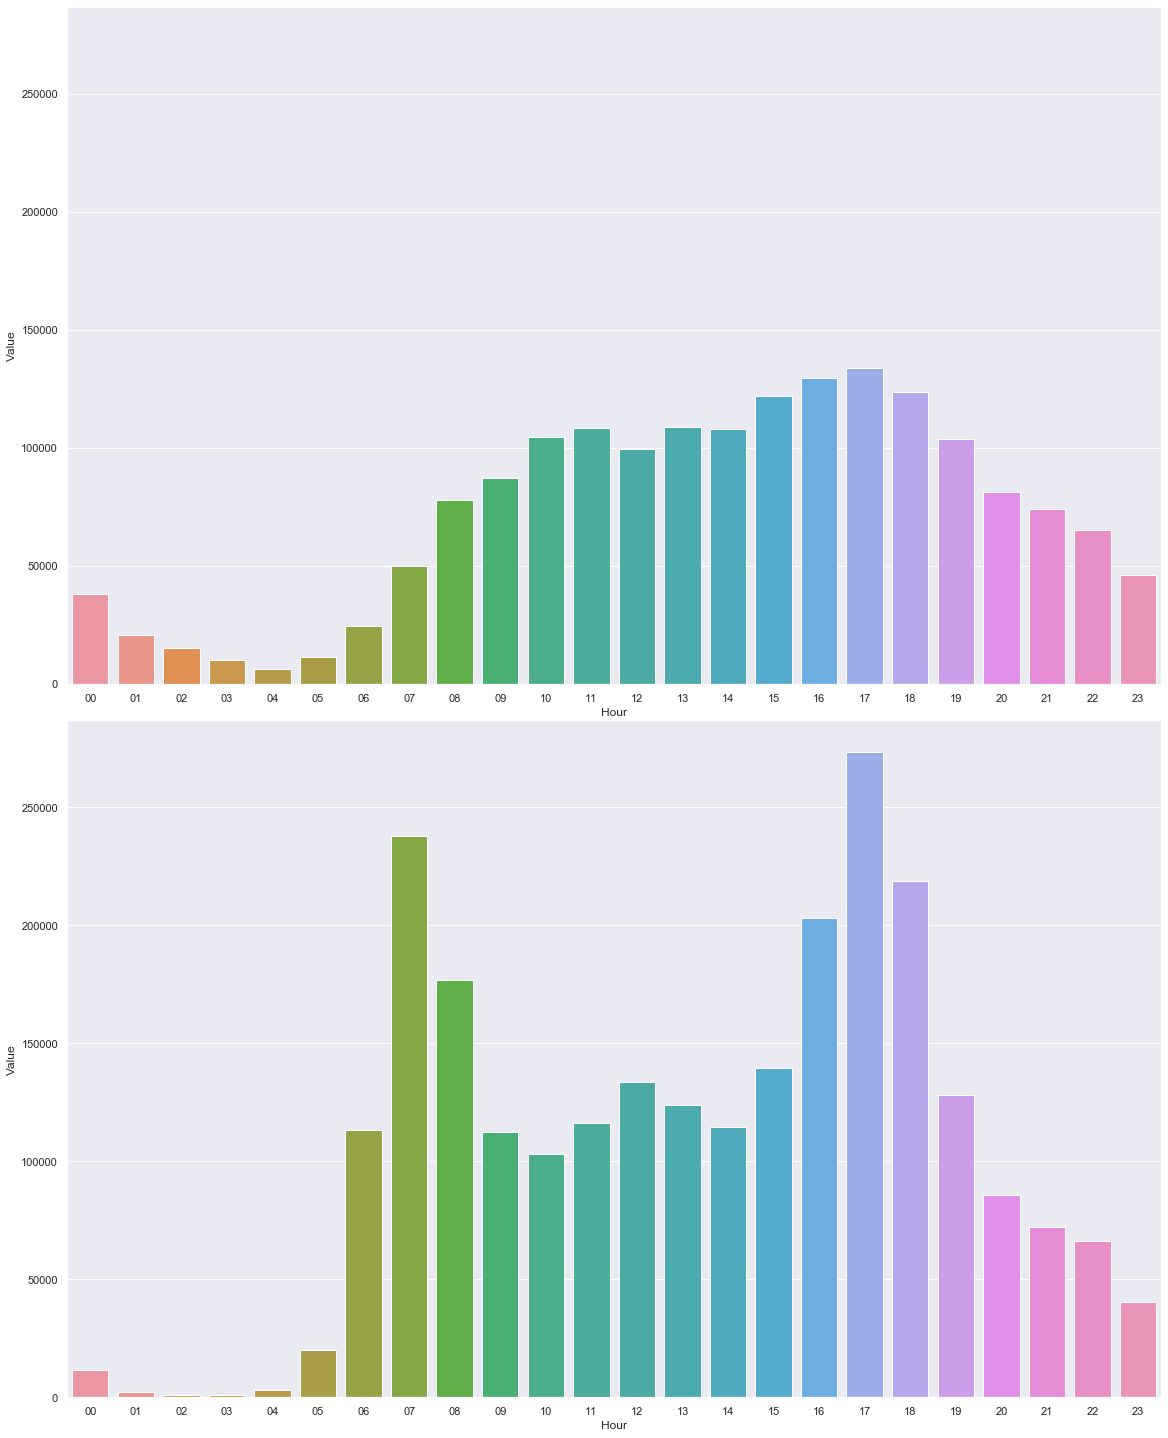

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(16, 20)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),  # average workday
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),  # average weekend day
    x="Hour",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)

## Time Slots

In [12]:
ax_data["TimeSlot"].value_counts()

Abend          1311431
Abend-Rush     1239244
Nachmittag     1050223
Morgen          903125
Morgen-Rush     812286
Nacht           502280
Mittag          354146
Name: TimeSlot, dtype: int64

### Plot sum(value) per time slot, scaled to one day

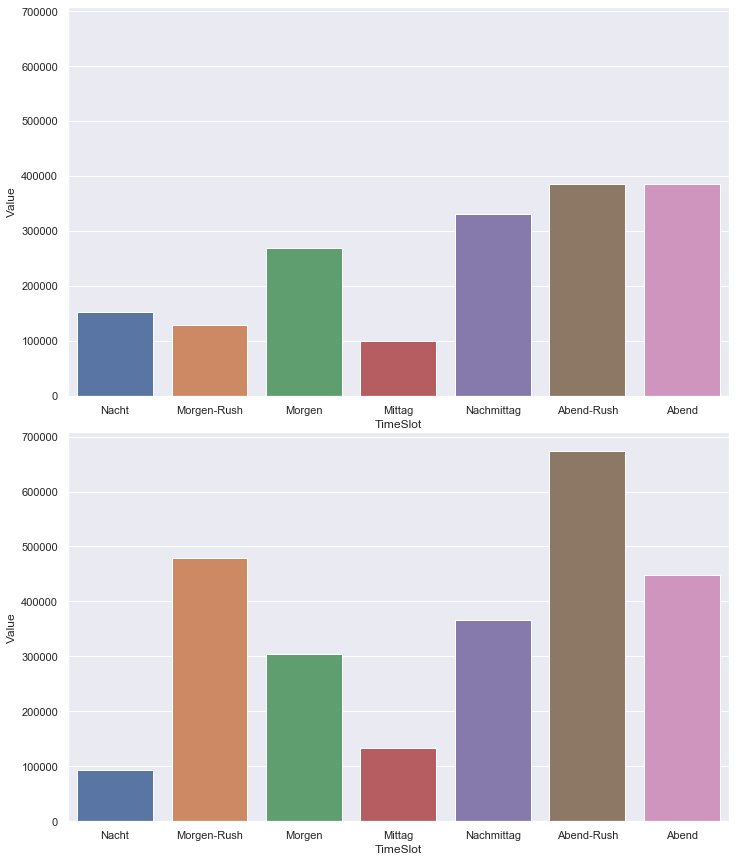

In [13]:
fig, (ax_weekend, ax_workdays) = plt.subplots(
    nrows=2, ncols=1, sharey="all", figsize=(10, 12)
)
plt.tight_layout()
sns.barplot(
    data=ax_data_weekends.eval("Value = Value / 2"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_weekend,
)
sns.barplot(
    data=ax_data_workdays.eval("Value = Value / 5"),
    x="TimeSlot",
    y="Value",
    estimator=np.sum,
    ci=None,
    ax=ax_workdays,
)

## Stations

In [14]:
ax_data.Station.value_counts()

Zürich HB                      484180
Bern                           393249
Lausanne                       324752
Zürich Stadelhofen             323222
Basel SBB                      303739
Zürich Hardbrücke              299255
Zürich Oerlikon                287498
Luzern                         285792
Winterthur                     278640
Olten                          268262
Genève Cornavin                264773
Aarau                          253015
Fribourg                       248304
Biel/Bienne                    242676
Zug                            241552
Lugano                         241111
Zürich Flughafen               229545
St. Gallen                     226524
Genève Aéroport                175364
Bellinzona                     152587
Neuchatel                      137868
Zürich Enge                    133672
Chur                           116690
Brig                           105993
M2                              68725
Zürich Flughafen - Airside      44408
Zürich Flugh

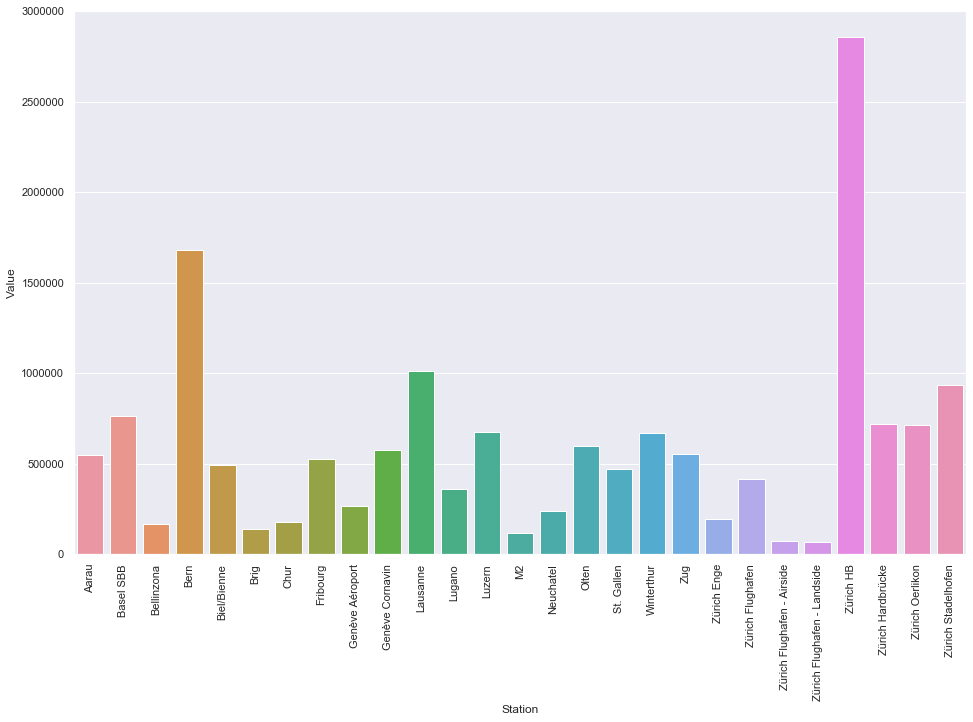

In [15]:
plt.figure(figsize=(16, 10))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Station", y="Value", ci=None, estimator=np.sum)

## Weekdays

In [16]:
ax_data.DayOfWeek.value_counts()

Friday       984452
Wednesday    922954
Thursday     891396
Saturday     888083
Tuesday      873917
Monday       843002
Sunday       768931
Name: DayOfWeek, dtype: int64

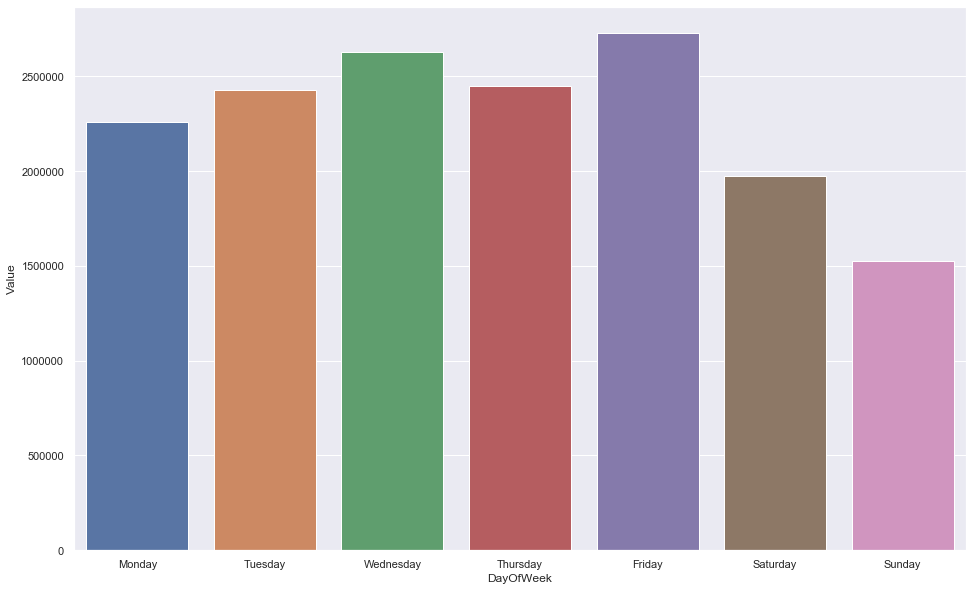

In [17]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="DayOfWeek",
    y="Value",
    ci="sd",
    estimator=np.sum,
    order=weekday_order,
)

## Months

In [18]:
ax_data.Month.value_counts()

08    1593196
05    1537462
07    1531483
06    1510594
Name: Month, dtype: int64

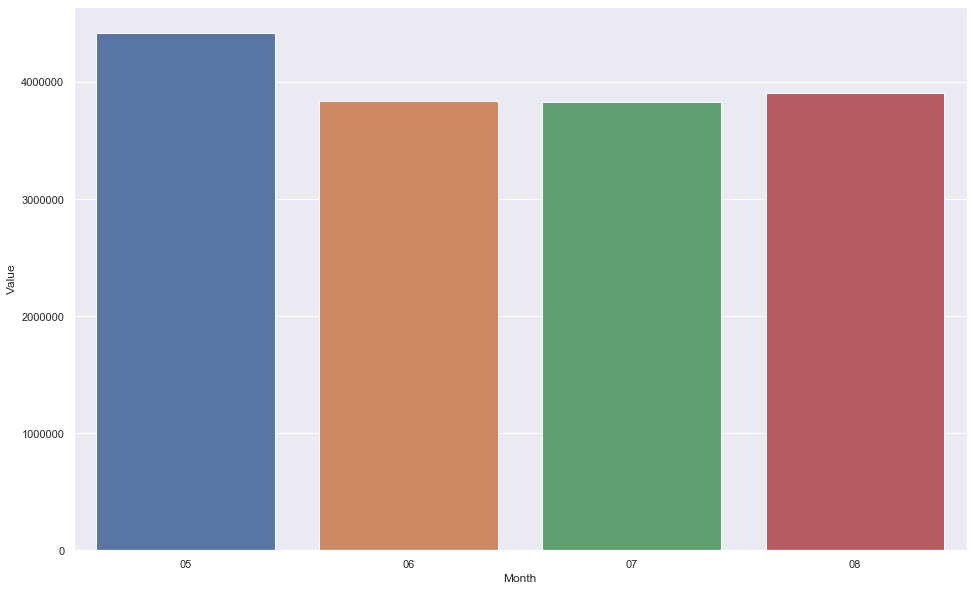

In [20]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="Month",
    y="Value",
    estimator=np.sum,
    ci=None
)

# Tests for Independence

In [40]:
from scipy.stats import chi2_contingency


def _var_factor_dependance(data, variable, factor, partitions):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, partition in subset.groupby(partitions):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = partition.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result


def factor_dependance(data, factor, partitions):
    all_var_assoc = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for v in var:
        var_assoc = _var_factor_dependance(
            data=data, variable=v, factor=factor, partitions=partitions
        ).query(f"p_{factor} <= 0.05")
        all_var_assoc = all_var_assoc.append(var_assoc, ignore_index=True, sort=False)
    all_var_assoc["VarDesc"] = lookup(
        ax_var_labels,
        target_col_name="Label",
        match_col=all_var_assoc["Var"],
        target_match_col_name="Variable",
    )
    return all_var_assoc

## For all variables, find stations where the distribution of codes is dependent on day time / time slot

In [41]:
%%time
all_var_assoc_time = factor_dependance(
    data=ax_data, factor="Time", partitions=["Station"]
)
all_var_assoc_timeslot = factor_dependance(
    data=ax_data, factor="TimeSlot", partitions=["Station"]
)

Wall time: 1min 37s


In [60]:
var_stations_time = pd.crosstab(
    index=all_var_assoc_time["VarDesc"].str.cat(all_var_assoc_time["Var"], sep=" [")
    + "]",
    columns=all_var_assoc_time["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_time, "var_by_station_vs_time.xlsx", sheet_name="contigency tab"
    )

2019-10-01 10:28:50 [INFO] Writing to file C:\Users\kpf\data\axinova\var_by_station_vs_time.xlsx
2019-10-01 10:28:50 [INFO] Written 16.3 KB
2019-10-01 10:28:50 [INFO] Finished writing xlsx file in 0.08s (0.09s CPU)


In [61]:
var_stations_timeslot = pd.crosstab(
    index=all_var_assoc_timeslot["VarDesc"].str.cat(
        all_var_assoc_timeslot["Var"], sep=" ["
    ) + ']',
    columns=all_var_assoc_timeslot["Label"],
    margins=True,
)

with project_dir("axinova"):
    write_xlsx(
        var_stations_timeslot,
        "var_by_station_vs_timeslot.xlsx",
        sheet_name="contigency tab",
    )

2019-10-01 10:29:29 [INFO] Writing to file C:\Users\kpf\data\axinova\var_by_station_vs_timeslot.xlsx
2019-10-01 10:29:29 [INFO] Written 16.4 KB
2019-10-01 10:29:29 [INFO] Finished writing xlsx file in 0.08s (0.06s CPU)


### Which variables have the most stations where their codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Var", as_index=False).agg(
    {"VarDesc": "max", "Label": ["count", collect]}
).set_axis(
    ["Variable", "VarDesc", "#", "Stations"], axis="columns", inplace=False
).sort_values(
    "#", ascending=False
).set_index(
    "Variable"
)

### Which stations have the most variables whose codes are time-dependent?

In [ ]:
all_var_assoc_time.groupby("Label", as_index=False).agg(
    {"Var": ["size", collect]}
).set_axis(["Station", "#", "Variables"], axis="columns", inplace=False).sort_values(
    "#", ascending=False
).set_index(
    "Station"
)

## For a single variable, show distribution of codes over time

In [62]:
import altair as alt

alt.data_transformers.enable("default", max_rows=None)

time_order = {"DayOfWeek": weekday_order, "TimeSlot": timeSlot_order}

def plot_var_time_dist(data, variable, over, station, as_percent=False):
    subset = (
        data.query("Station == @station and Variable == @variable")
        .pipe(clean_up_categoricals)
        .copy()
    )
    codes_sorted = variable in var_code_order
    if codes_sorted:
        subset["Code_order"] = subset["Code"].replace(var_code_order[variable])
        code_list_sorted = list(var_code_order[variable])
    chart = (
        alt.Chart(subset)
        .mark_bar()
        .encode(
            x=alt.X("sum(Value)", stack="normalize") if as_percent else "sum(Value)",
            y=alt.Y(
                over,
                sort=time_order.get(over, "ascending"),
            ),
            color=alt.Color(
                "Code",
                sort=code_list_sorted if codes_sorted else "ascending",
                scale=alt.Scale(scheme="spectral" if codes_sorted else "category20"),
            ),
            order=alt.Order("Code_order") if codes_sorted else alt.Order("Code"),
        )
        .configure_view(width=800)
        .properties(
            title=f"{var_label(variable)} | {over} [{station}]"
            + (", Prozent" if as_percent else "")
        )
    )
    return chart

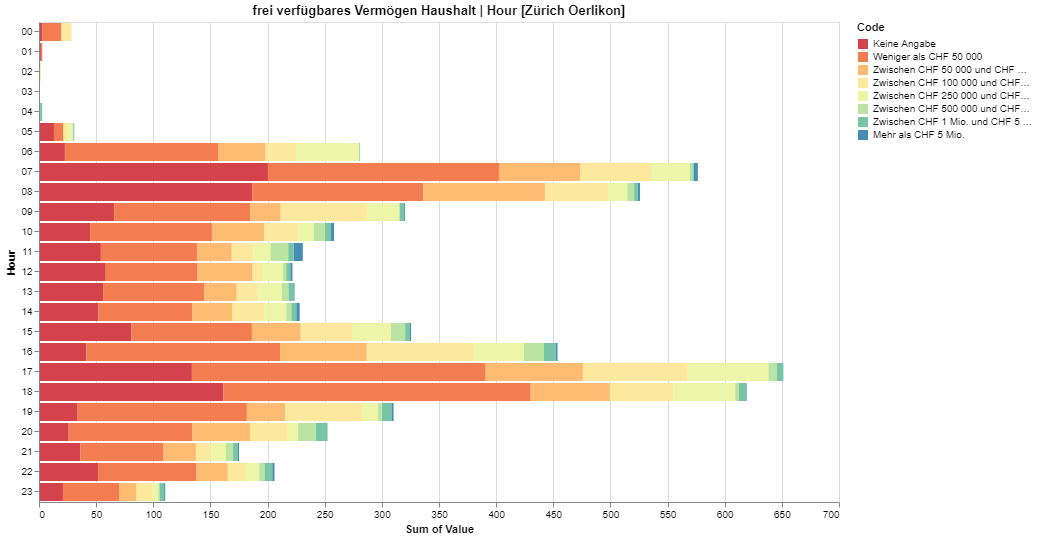

In [67]:
plot_var_time_dist(
    data=ax_data_workdays,
    variable=var.md_hhverm,
    over="Hour",
    station="Zürich Oerlikon",
    as_percent=False,
)

# ANOVA

In [68]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [72]:
def anova_table(aov):
    """Calculate ANOVA table"""
    aov["mean_sq"] = aov[:]["sum_sq"] / aov[:]["df"]
    aov["eta_sq"] = aov[:-1]["sum_sq"] / sum(aov["sum_sq"])
    aov["omega_sq"] = (aov[:-1]["sum_sq"] - (aov[:-1]["df"] * aov["mean_sq"][-1])) / (
        sum(aov["sum_sq"]) + aov["mean_sq"][-1]
    )
    cols = ["sum_sq", "df", "mean_sq", "F", "PR(>F)", "eta_sq", "omega_sq"]
    aov = aov[cols]
    return aov


def calc_anova(data, variable, formula="logValue ~ Code + Station + DayOfWeek"):
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)
    subset = subset.assign(
        label=subset.Station.str.cat([subset.DayOfWeek.str[:3], subset.Code], sep="|")
    )
    subset.set_index("label", inplace=True)
    mod = smf.ols(formula=formula, data=subset)
    res = mod.fit()
    print(f"Variable: {var_label(variable)}")
    display(anova_table(anova_lm(res, typ=2)))
    print(res.summary())


def anova_stats(data, variable):
    """ANOVA statistics"""
    subset = data.loc[data.Variable == variable].pipe(clean_up_categoricals)

    lm_base = smf.ols(formula="logValue ~ Code:TimeSlot:DayOfWeek", data=subset).fit()
    lm_base_station = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station", data=subset
    ).fit()
    lm_base_station_month = smf.ols(
        formula="logValue ~ Code:TimeSlot:DayOfWeek + Station + Month", data=subset
    ).fit()
    return {
        "var": variable,
        "base": lm_base.rsquared,
        "base+station": lm_base_station.rsquared,
        "base+station+month": lm_base_station_month.rsquared,
    }

In [73]:
%%time
all_var_stats = pd.DataFrame.from_records(
    columns="var base base+station base+station+month".split(),
    data=[anova_stats(ax_data_workdays, v) for v in var.keys()],
    index="var",
)

all_var_stats = all_var_stats.assign(
    **{
        "plus_station": all_var_stats["base+station"] - all_var_stats["base"],
        "plus_month": all_var_stats["base+station+month"]
        - all_var_stats["base+station"],
        "plus_station_month": all_var_stats["base+station+month"]
        - all_var_stats["base"],
    }
)

Wall time: 16min 11s


In [71]:
all_var_stats.sort_values("base+station+month", ascending=False).loc[
    :, "base plus_station plus_month base+station+month".split()
]

,base,plus_station,plus_month,base+station+month
var,,,,
g_503,0.126885,0.407876,0.006659,0.541420
g_508,0.127625,0.397409,0.005625,0.530659
g_507,0.162075,0.359084,0.005757,0.526916
md_319,0.158765,0.344997,0.005722,0.509485
md_upc,0.202865,0.302096,0.004313,0.509275
md_mbudget,0.202865,0.302096,0.004313,0.509275
g_504,0.121859,0.376510,0.007142,0.505512
g_501,0.211979,0.287949,0.005071,0.504999
md_hhu6,0.246856,0.253773,0.004289,0.504917


In [75]:
calc_anova(ax_data_workdays, var.g_220, formula='logValue ~ Code:TimeSlot:DayOfWeek + Station + Month')

Variable: Anzahl Autos im Haushalt


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
Station,7516.379638,26.0,289.091525,881.923377,0.000000e+00,0.255070,0.254778
Month,138.331347,3.0,46.110449,140.667849,8.077818e-91,0.004694,0.004661
Code:TimeSlot:DayOfWeek,2706.947556,104.0,26.028342,79.403930,0.000000e+00,0.091861,0.090703
Residual,19106.283072,58287.0,0.327797,NaN,NaN,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:               logValue   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     227.3
Date:                Tue, 01 Oct 2019   Prob (F-statistic):               0.00
Time:                        11:35:19   Log-Likelihood:                -50248.
No. Observations:               58421   AIC:                         1.008e+05
Df Residuals:                   58287   BIC:                         1.020e+05
Df Model:                         133                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------